In [2]:

import sys
sys.path.insert(0, '/Users/anis/test_labnbook/Indicators/scripts')  
import json, gzip,ujson
import pandas as pd 
from  utils.utils  import get_authors_changes
import numpy as np, toml
from typing import Tuple, List, Dict
import mysql.connector as mariadb
import warnings    
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows',700)

from flow_3 import * 
from utils.utils import *
import seaborn as sns 

# password = "11950022"
# host = "localhost"
# database_name  = "Labnbook"
# user = 'root'
# try:
#     conn = mariadb.connect(user=user, password=password,
#                            host=host, database=database_name)
# except mariadb.Error as e:
#     print(f"Error connecting to MariaDB Platform: {e}")

# # Récupération du curseur
# cursor = conn.cursor()
# trace = pd.read_sql(
#     " SELECT id_trace, id_labdoc,id_user ,id_action, action_time from trace Order By id_labdoc ASC, action_time ASC", conn)
# # WHERE  id_action=9 

,id_trace,id_labdoc,id_user,n_modify_id,effective_time,id_labdoc_y,action_time,id_mission,id_report,n_users,teacher,n_tokens,n_segments,eqc,coec,user,sim
0,5455308,323357,10706,18,540,323357,2020-11-16 09:11:02,451,35694,1,0,32,1,0.0,0.00,10706,1.00
1,5457355,323357,10727,11,330,323357,2020-11-16 10:07:17,451,35694,2,0,37,2,0.8,0.15,10727,0.52
2,5461072,323370,10727,35,1050,323370,2020-11-16 11:36:42,451,35694,1,0,203,8,0.0,0.00,10727,1.00
3,5462296,323362,10727,39,1170,323362,2020-11-16 12:13:46,451,35694,1,0,68,3,0.0,0.00,10727,1.00
4,5459926,323366,10727,18,540,323366,2020-11-16 11:09:48,451,35694,1,0,134,5,0.0,0.00,10727,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12884,8356088,473891,12099,16,480,473891,2021-05-09 14:00:56,1694,47058,1,0,45,3,0.0,0.00,12099,1.00
12885,8367872,476308,12089,4,120,476308,2021-05-09 23:29:42,1694,47073,1,0,238,10,0.0,0.00,12089,1.00
12886,8368000,476307,12089,7,210,476307,2021-05-09 23:34:29,1694,47073,1,0,183,10,0.0,0.00,12089,1.00
12887,8367979,476305,12089,10,300,476305,2021-05-09 23:33:44,1694,47067,1,0,183,10,0.0,0.00,12089,1.00


<Axes: >

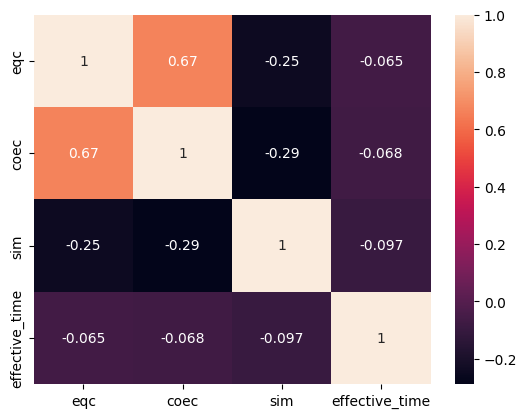

In [11]:
sns.heatmap(df[["eqc","coec","sim","effective_time"]].corr(),annot = True)

In [17]:
selected_labdoc =445494
# Import all summary
summary_all  = pd.read_csv('/Users/anis/test_labnbook/Indicators/data/tmp/reports/summary_all.csv', index_col = [0])
summary_labdoc = summary_all[summary_all["id_labdoc"] == int(selected_labdoc)]
summary_labdoc.drop(['id_mission','id_report','id_labdoc'],axis =1, inplace = True)
summary_labdoc['action_time'] = pd.to_datetime(summary_labdoc['action_time'])
summary_labdoc['edition_time'] = summary_labdoc['action_time'].diff()
summary_labdoc["id_trace"] = summary_labdoc["id_trace"].astype(str)
summary_labdoc.set_index('id_trace',inplace=True)
summary_labdoc['1-sim'] = 1 - summary_labdoc["sim"]
edition_time = summary_labdoc['edition_time']
summary_labdoc["edition_time"] = summary_labdoc["edition_time"].astype(str)
summary_labdoc["action_time"] = summary_labdoc["action_time"].astype(str)

In [40]:
times_all = pd.read_csv("/Users/anis/test_labnbook/Indicators/data/tmp/reports/3_times.csv",index_col=[0])
times_labdoc = times_all[times_all["id_labdoc_x"]==selected_labdoc]
times_labdoc.rename(columns={"id_labdoc_x": "id_labdoc"},inplace =True)
times_labdoc.drop(["id_labdoc_y"], axis = 1 , inplace = True)
times_labdoc = times_labdoc.set_index("id_trace")
times_labdoc.index = times_labdoc.index.astype(str)
times_labdoc_thin = times_labdoc[["n_modify_id","effective_time","teacher"]]


In [41]:
pd.merge(times_labdoc_thin,summary_labdoc, left_index=True, right_index=True)

,n_modify_id,effective_time,teacher_x,action_time,n_users,teacher_y,n_tokens,n_segments,eqc,coec,user,sim,edition_time,1-sim
id_trace,,,,,,,,,,,,,,
7481881,23,690,1,2021-03-16 10:05:29,2,1,112,3,0.000000,0.000000,12673,0.69,NaT,0.31
7482763,4,120,1,2021-03-16 11:18:11,3,1,111,3,0.042793,0.045333,12661,1.00,0 days 01:12:42,0.00
7482817,14,420,1,2021-03-16 11:21:13,3,1,121,6,0.066413,0.070133,12673,1.00,0 days 00:03:02,0.00
7482845,2,60,1,2021-03-16 11:22:42,3,1,121,6,0.066413,0.070133,12661,1.00,0 days 00:01:29,0.00
7505160,58,1740,1,2021-03-18 08:49:40,3,1,150,8,0.118471,0.150075,12673,0.98,1 days 21:26:58,0.02


In [42]:
import os 

'/Users/anis/test_labnbook/Indicators/tests/notebooks'